Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune Gemma 3 270M for emoji generation

This notebook fine-tunes Gemma for the task of translating text into emoji using Quantized Low-Rank Adaptation (QLoRA) through the Hugging Face Transformers library to help reduce memory usage and speed up the fine-tuning process.

When training [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m) on a Google Colab T4 GPU accelerator, this process can take as little as 10 minutes end-to-end. Run each code snippet to:

1. Set up the Colab environment
2. Prepare a dataset for fine-tuning
3. Load and test the base Gemma 3 270M model
4. Fine-tune the model
5. Test, evaluate, and save the model for further use

## Set up development environment

The first step is to install the necessary libraries using the `pip` package installer, which handles dependencies.

In [1]:
%pip install torch tensorboard emoji
%pip install -U transformers trl datasets accelerate evaluate sentencepiece bitsandbytes protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      S

You may have the restart your session (runtime) to use newly installed libraries.

##Enable Hugging Face permissions
To start using Gemma models, you'll need a Hugging Face account that has accepted the model usage license and and created an Access Token.

1. **Accept usage license** on the [model page](http://huggingface.co/google/gemma-3-270m-it).

2. **Get a valid [Access Token](https://huggingface.co/settings/tokens) with 'Write' access (very important!)** and create a new secret in the left toolbar. Specify `HF_TOKEN` as the 'Name', add your unique token as the 'Value', and toggle 'Notebook access'.

In [2]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

## Prepare the dataset

You can customize the Gemma 3 270M model to use specific emoji by creating a .csv spreadsheet containing your text-to-emoji dataset structured as key-value pairs. To encourage memorization of specific emoji, provide at least 20 examples in your dataset.

Use our [premade dataset](https://github.com/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Emoji%20Translation%20Dataset%20%20-%20Dataset.csv) or this [spreadsheet](https://github.com/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Emoji%20Translation%20Dataset%20Template%20-%20Dataset.csv) as a template to create your own dataset, then upload it to session storage in the Files folder in the left toolbar. Get its path by right-clicking the file and pointing to it in `custom_dataset_path`.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

custom_dataset_path = "/content/Emoji Translation Dataset - Dataset.csv"      # Point to your uploaded dataset
dataset = load_dataset("csv", data_files=custom_dataset_path, encoding="utf-8", split="train")

print(f"Here's the 10th example from your custom dataset: {dataset[10]}")

Here's the 10th example from your custom dataset: {'text': 'A crisp and cool autumn morning', 'emoji': '🍂🍁☕️🧡'}


### Use a Hugging Face dataset
**If you've already loaded a dataset, skip this step.**

Hugging Face has a vast collection of datasets used to train and evaluate large language models (LLM). For the text-to-emoji task, you can use the [KomeijiForce/Text2Emoji](https://huggingface.co/datasets/KomeijiForce/Text2Emoji) dataset containing examples of text and corresponding emoji translations.

As a preprocessing step, we'll use the [emoji](https://carpedm20.github.io/emoji/docs/) library to check that the training dataset "outputs" contain only emoji characters.

In [ ]:
import emoji
from datasets import load_dataset

# Use the first 2000 samples for efficient training.
general_dataset_path = load_dataset("KomeijiForce/Text2Emoji", encoding="utf-8", split="train[:2000]")

# Clean dataset to only use examples where 'emoji' field contains only emoji characters
def is_only_emoji(sample):
  emoji_string = sample['emoji']
  if not emoji_string:
    return False
  return all(emoji.is_emoji(char) for char in emoji_string)
dataset = general_dataset_path.filter(is_only_emoji)

print(f"\nHere's the 10th example from the dataset: {dataset[10]}")

### Format the training dataset
Now that you've loaded your data, formatting it in conversational roles helps the model learn how to interpret the 'text' and 'emoji' columns from your dataset alongside a system prompt that contains the task instruction.

In [ ]:
from transformers import AutoTokenizer

def translate(sample):
  return {
      "messages": [
          {"role": "system", "content": "Translate this text to emoji: "},
          {"role": "user", "content": f"{sample['text']}"},
          {"role": "assistant", "content": f"{sample['emoji']}"}
      ]
  }

training_dataset = dataset.map(translate, remove_columns=dataset.features.keys())
training_dataset_splits = training_dataset.train_test_split(test_size=0.1, shuffle=True)

print("\nHere's an example from the formatted training dataset:")
print(training_dataset[50])

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]


Here's an example from the formatted training dataset:
{'messages': [{'content': 'Translate this text to emoji: ', 'role': 'system'}, {'content': 'Always fishing for compliments', 'role': 'user'}, {'content': '🎣🙄😒', 'role': 'assistant'}]}


## Load the model

You can access the [Gemma 3 270M model](https://huggingface.co/google/gemma-3-270m-it) from Hugging Face Hub by accepting the license terms.

The instruction-tuned version of the model has already been trained on how to follow directions, enabling fine-tuning with fewer training examples and in less time.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

gemma_model = "google/gemma-3-270m-it"
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto", attn_implementation="eager", dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

print(f"Device: {base_model.device}")
print(f"DType: {base_model.dtype}")

### Map special emoji characters

Gemma 3 270M features a 256k token vocabulary, enabling it to handle specific and rare tokens. Some emojis aren't part of Gemma's base vocabulary, so this step ensures the emojis in your dataset are mapped to one of the model tokenizer's `<unused>` placeholder tokens before fine-tuning.

In [ ]:
# Identify special tokens in your data that are not in the base vocabulary
unk_token_id = tokenizer.unk_token_id
unique_chars_in_data = {char for emoji_string in dataset['emoji'] if emoji_string for char in emoji_string}
special_tokens_in_data = {char for char in unique_chars_in_data if tokenizer.convert_tokens_to_ids(char) == unk_token_id}

# Get the list of available unused tokens that are already in the vocabulary
available_placeholders = [token for token in tokenizer.get_vocab().keys() if token.startswith("<unused")]
if len(special_tokens_in_data) > len(available_placeholders):
    raise ValueError("Not enough unused tokens to map all special tokens in the dataset.")

# Create unused token mapping
token_map = {special: unused for special, unused in zip(special_tokens_in_data, available_placeholders)}
def replace_special_tokens(example):
    if example['emoji']:
        example['emoji'] = "".join(token_map.get(char, char) for char in example['emoji'])
    return example

print("Mapped {len(special_tokens_in_data)} special token(s):", token_map)

Device should print as `cuda` if you're using a GPU runtime. **If you haven't aleady, use a free T4 GPU runtime in your Colab for faster fine-tuning.**

### Recommended: Test the base model

Let's first check how the base model's ability to respond to the instruction "Translate this text to emoji".

Try testing it a few times.

In [ ]:
from transformers import pipeline
from random import randint
import re

# Create a transformers inference pipeline
pipe = pipeline("text-generation", model=gemma_model, tokenizer=tokenizer)

# Select a random sample from the test dataset
rand_idx = randint(0, len(training_dataset_splits["test"]) - 1)
test_sample = training_dataset_splits["test"][rand_idx]

# Handle messages
all_messages = test_sample['messages']
user_message_content = next((msg['content'].strip() for msg in all_messages if msg['role'] == 'user'), "Not Found")
dataset_emoji = next((msg['content'].strip() for msg in all_messages if msg['role'] == 'assistant'), "Not Found")
prompt_messages = [
    {"role": "system", "content": "Translate this text to emoji: "},
    {"role": "user", "content": user_message_content}
]

# Apply the chat template. This will format the messages correctly for the model.
prompt = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)

# Generate the output
output = pipe(prompt, max_new_tokens=64)
model_output_only = output[0]['generated_text'][len(prompt):].strip()

print(f"\nDataset text: {user_message_content}")
print(f"\nDataset emoji: {dataset_emoji}")
print(f"\nModel generated output: {model_output_only}")

**You'll see that the base model does not generate a good emoji combination.** It might not output emoji within its response at all!

That's because the Gemma 3 270M model size was designed for task hyper-specialization, which means it can improve performance for specific use cases when fine-tuned with representative examples. While the instruction-tuned model's previous training makes the translation task easier to learn, it's best to provide as many  examples in your dataset as possible.

Now, you'll train the model with new data so it more reliably generates emoji.

## Fine-tune the model

Transformer Reinforcement Learning ([TRL](https://huggingface.co/docs/trl/index)) is a library that provides tools for training and fine-tuning LLMs using advanced techniques like QLoRA (Quantized Low-Rank Adaptation) to train adapters on top of a frozen quantized version of the model.

### Configure the tuning job
Define the training hyperparameters for the Gemma 3 base model:

1. `BitsandBytesConfig` to quantize the model for memory efficiency
2. `LoraConfig` for parameter-efficient fine-tuning
2. `SFTConfig` for supervised fine-tuning

QLoRA fine-tuning produces a set of adapters that we'll save to the Colab session storage so we can test model performance.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig
from trl import SFTConfig

gemma_model = "google/gemma-3-270m-it"
adapter_path = "/content/myemoji-gemma-adapters"      # Where to save your LoRA adapters
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules="all-linear",                      # Target all linear layers
    lora_dropout=0.05,                                # Increase to 0.1 to induce overfitting
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"]       # Save the lm_head and embed_tokens as you train the special tokens
)

args = SFTConfig(
    output_dir=adapter_path,                          # Directory to save adapters
    num_train_epochs=2,                               # Number of training epochs
    per_device_train_batch_size=4,                    # Batch size per device during training
    logging_strategy="epoch",                         # Log every epoch
    eval_strategy="epoch",                            # Evaluate loss metrics every epoch
    save_strategy="epoch",                            # Save checkpoint every epoch
    learning_rate=5e-5,                               # Learning rate
    lr_scheduler_type="constant",                     # Use constant learning rate scheduler
    max_length=256,                                   # Max sequence length for model and packing of the dataset
    gradient_checkpointing=False,                     # Use gradient checkpointing to save memory
    packing=False,                                    # Groups multiple samples in the dataset into a single sequence
    optim="adamw_torch_fused",                        # use fused adamw optimizer
    report_to="tensorboard",                          # Report metrics to tensorboard
    weight_decay=0.01,                                # Added weight decay for regularization
)

base_model = AutoModelForCausalLM.from_pretrained(gemma_model, quantization_config=bnb_config, device_map="auto", attn_implementation='eager')
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Training configured.")

### Start training

`SFTTrainer` tokenizes the training and evaluation datasets and trains the base model using the parameters from the previous step.

**This shouldn't take more than 5 minutes** using GPU acceleration for 500 training examples. If your training is going slowly, check that you're using a T4 GPU in Colab.

In [ ]:
from trl import SFTConfig, SFTTrainer

# Set the training and evaluation datasets
train_dataset = training_dataset_splits['train']
eval_dataset = training_dataset_splits['test']

# Fine-tune the model and save the LoRA adapters
trainer = SFTTrainer(
    model=base_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
)

trainer.train()
trainer.save_model(adapter_path)

print(f"LoRA adapters saved to {adapter_path}")

The LoRA adapters for each training checkpoint (epoch) will be saved in your temporary Colab session storage. You can choose which adapters to merge into the model. But first, take a look at the results.

### Plot training results
To evaluate the model, you can plot the training and validation losses. Libraries like Matplotlib can then be used to visualize these values over training steps or epochs. This visualization helps in monitoring the training process and making informed decisions about hyperparameters tuning or early stopping.

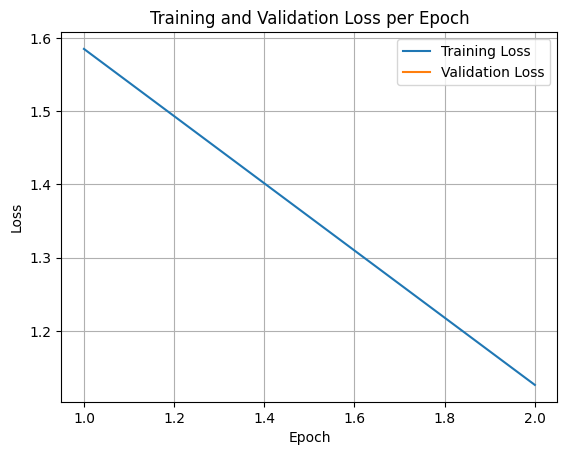

In [ ]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Training loss measures the error on the data the model was trained on. Validation loss measures the error on a separate dataset the model has not seen before. Monitoring both helps detect overfitting (when the model performs well on training data but poorly on unseen data).

- validation loss >> training loss: **overfitting**
- validation loss > training loss: **some overfitting**
- validation loss < training loss: **some underfitting**
- validation loss << training loss: **underfitting**

Overfitting is when the model can make accurate predictions on examples seen in its training but performs poorly with unseen data. If your task requires memory of specific examples, or specific emoji to be generated for a given text, overfitting can be a good thing.

### Merge the adapters

Once trained you can merge the LoRA adapters with the model. You can choose which adapters to merge by specifying the training checkpoint folder, otherwise it will default to the last epoch.
* For better task generalization, choose the most underfit checkpoint (validation loss < training loss)
* For better memorization of specific examples, choose the most overfit (checkpoint > training loss)  



In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

gemma_model = "google/gemma-3-270m-it"                            # Base model to merge from Hugging Face Hub
adapter_path = "/content/myemoji-gemma-adapters/"                 # Choose which adapters to merge, otherwise defaults to latest
merged_model_path = "/content/myemoji-gemma-merged/"              # Location of merged model directory

# Load base model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

# Load and merge the PEFT adapters onto the base model
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

# Save the merged model and its tokenizer
model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)

print(f"Model merged and saved to {merged_model_path}. Final model vocabulary size: {model.config.vocab_size}")

The vocabulary size of the fine-tuned model should be the same as the base model (262144) to ensure compatibility for different runtimes.

### Test the fine-tuned model

After the training is done and you've merged the adapters to the base model, you can test different user inputs for your fine-tuned model by updating `text_to_translate`.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Create Transformers inference pipeline
merged_model = AutoModelForCausalLM.from_pretrained(merged_model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(merged_model_path)
pipe = pipeline("text-generation", model=merged_model, tokenizer=tokenizer)

# Test a prompt
text_to_translate = "let's go to Japan"  #@param {type:"string"}
inference_messages = [
    {"role": "system", "content": "Translate this text to emoji: "},
    {"role": "user", "content": text_to_translate}
]
prompt = tokenizer.apply_chat_template(inference_messages, tokenize=False, add_generation_prompt=True)
output = pipe(prompt, max_new_tokens=64)
model_output = output[0]['generated_text']

print(f"{model_output}")

Does the model output the emoji you'd expect?

If you're not getting the results you want, you can try [retraining the model](#scrollTo=-BJFoOdL0y8w) using different parameters, or updating your training dataset to contain more representative examples.

Once you're happy with the results, you can save your model to Hugging Face Hub for easy access.

## Save your model and upload to Hugging Face Hub
**You now have a customized Gemma 3 270M model! 🎉**

You can now download the merged model (or just your LoRA adapters) to the Download folders on your local machine, or upload to a repository on Hugging Face so you easily share your model or access it later for conversion.

In [ ]:
# Name your fine-tuned model
model_name = "myemoji"      #@param {type:"string"}

### Upload to Hugging Face
Upload your merged model to [Hugging Face](https://huggingface.co/) for easy sharing and future use.

In [ ]:
from huggingface_hub import whoami, HfApi
from peft import PeftModel

user_info = whoami()
username = user_info['name']
repo_id = f"{username}/{model_name}-gemma-3-270m-it"
api = HfApi()
api.create_repo(repo_id=repo_id, exist_ok=True)
api.upload_folder(folder_path=merged_model_path, repo_id=repo_id, repo_type="model")

## Next steps

This notebook covered how to perform QLoRA fine-tuning on Gemma 3 270M using the Transformers TRL library. Now you can use your customized model in apps!

### Run your model on-device

To run your fine-tuned model on-device, continue on to the conversion and quantization steps. To run your emoji generation model directly in the browser, you can follow the steps to either:

1.  [Convert for use with MediaPipe LLM Inference API](https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Convert_Gemma_3_270M_to_ONNX.ipynb)
2.  [Convert for use with Transformers.js via ONNX Runtime](https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Convert_Gemma_3_270M_to_ONNX.ipynb)

> Tip: When converting or running inference with your fine-tuned model, you'll get the best performance by using the same chat template it was trained on:
> ```
> <bos><start_of_turn>user
> Translate this text to emoji.
>
> {input}<end_of_turn>
> <start_of_turn>model
> {output}
> ```